<a href="https://colab.research.google.com/github/Freemanlabs/giz-rwanda-ai-training/blob/master/cv-with-pytorch/03_cnn/cnn.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introducing CNN

So far, we’ve learned how to build deep neural networks and the impact of tweaking their various hyperparameters. In this chapter, we will learn about where traditional deep neural networks do not work. We’ll then learn about the inner workings of convolutional neural networks (CNNs) by using a toy example before understanding some of their major hyperparameters, including stride, pooling, and filters. Next, we will leverage CNNs, along with various data augmentation techniques, to solve the issue of traditional deep neural networks not having good accuracy. Following this, we will learn what the outcome of a feature learning process in a CNN looks like. Finally, we’ll bring our learning together to solve a use case: we’ll be classifying an image by stating whether the image contains a dog or a cat. By doing this, we’ll be able to understand how the accuracy of prediction varies by the amount of data available for training.

By the end of this chapter, you will have a deep understanding of CNNs, which form the backbone of multiple model architectures that are used for various tasks.

The following topics will be covered in this chapter:

- The problem with traditional deep neural networks
- Building blocks of a CNN
- Implementing a CNN
- Classifying images using deep CNNs
- Implementing data augmentation
- Building a CNN for classifying real-world images

Let's get started!

## The problem with traditional deep neural networks

Before we dive into CNNs, let’s look at the major problem that’s faced when using traditional deep neural networks.

Let’s reconsider the model we built on the Fashion-MNIST dataset in the last chapter. We will fetch a random image and predict the class that corresponds to that image, as follows:

In [ ]:
# @title Broilerplate

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_folder = 'data/FMNIST' # This can be any directory you want to download FMNIST to

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

@torch.no_grad()
def accuracy(prediction, y):
    preds = prediction.argmax(dim=-1)
    is_correct = preds == y
    return is_correct.cpu().numpy().tolist()


def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item(), prediction


@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item(), prediction


def train(model, loss_fn, optimizer, trn_dl, val_dl, n_epochs=5):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(n_epochs):
        train_epoch_losses, train_epoch_accuracies = [], []
        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            batch_loss, prediction = train_batch(x, y, model, optimizer, loss_fn)
            train_is_correct = accuracy(prediction, y)

            train_epoch_losses.append(batch_loss)
            train_epoch_accuracies.extend(train_is_correct)
        
        train_epoch_loss = np.mean(train_epoch_losses)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)
        
        val_epoch_losses, val_epoch_accuracies = [], []
        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_batch_loss, prediction = val_loss(x, y, model, loss_fn)
            val_is_correct = accuracy(prediction, y)

            val_epoch_losses.append(val_batch_loss)
            val_epoch_accuracies.extend(val_is_correct)
    
        val_epoch_loss = np.mean(val_epoch_losses)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        torch.cuda.empty_cache()
        print(f"Epoch {epoch}:\tTrain Loss: {train_epoch_loss:.4f}\tTrain Accuracy: {train_epoch_accuracy:.4f}\tVal Loss: {val_epoch_loss:.4f}\tVal Accuracy: {val_epoch_accuracy:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = np.arange(len(train_losses)) + 1

    # First plot (losses)
    plt.subplot(211)
    plt.plot(epochs, train_losses, "b", label="Training loss")
    plt.plot(epochs, val_losses, "r", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title("Training and validation loss with no hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid("off")
    # plt.show()

    # Second plot (accuracies)
    plt.subplot(212)
    plt.plot(epochs, train_accuracies, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title("Training and validation accuracy with no hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    plt.legend()
    plt.grid("off")
    
    plt.tight_layout()
    plt.show()


# Load the DNN model from the previous chapter
def get_model_ch3():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(), 
                nn.Linear(1000, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

model, _, _ = get_model_ch3()
model.load_state_dict(torch.load('models/fmnist-dnn.pth', map_location=device))
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=10, bias=True)
)

1. Fetch a random image from the available training images:

Text(0.5, 1.0, 'Trouser')

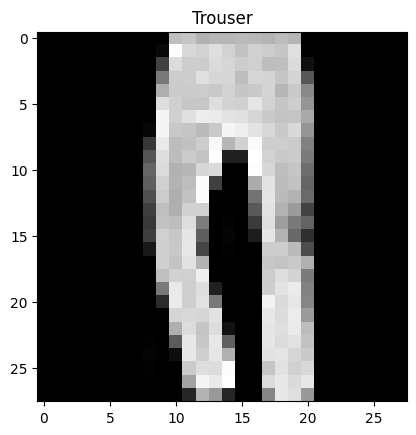

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# ix = np.random.randint(len(tr_images))
ix = 24300

plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

2. Pass the image through the trained model (from the last chapter):

    1. Preprocess the image so it goes through the same preprocessing steps we performed while building the model:

In [3]:
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

2. 
    2. Extract the probabilities associated with the various classes:

In [4]:
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([5.0712597e-02, 9.4638169e-01, 1.5058996e-05, 3.5494662e-04,
       1.0471035e-04, 1.5158127e-09, 2.4299442e-03, 1.2084736e-14,
       1.0531171e-06, 5.2573562e-10], dtype=float32)

3. Translate (roll/slide) the image multiple times (one pixel at a time) from a translation of 5 pixels to the left to 5 pixels to the right and store the predictions in a list:

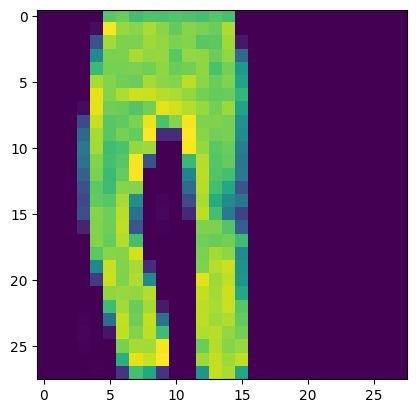

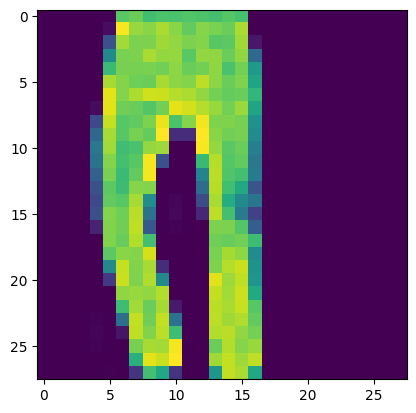

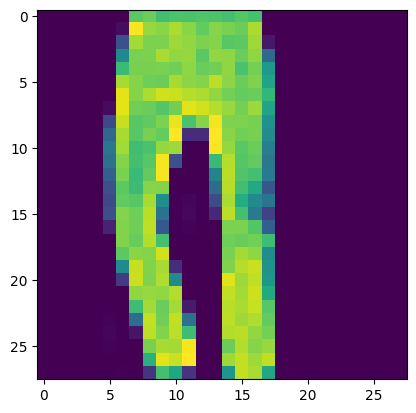

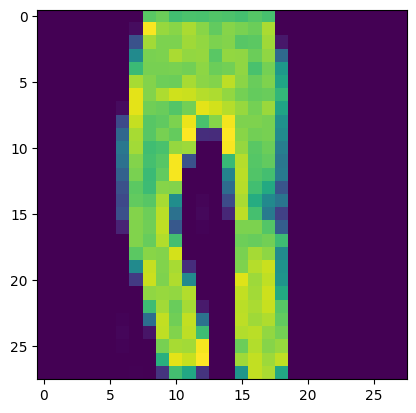

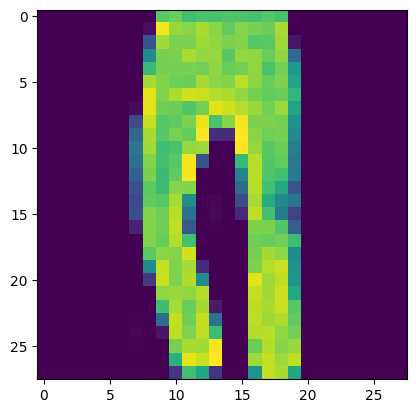

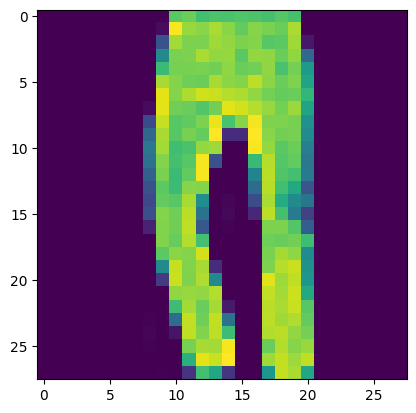

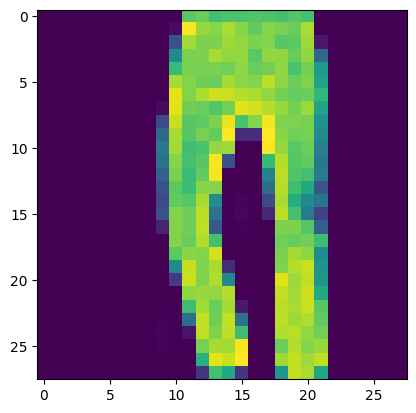

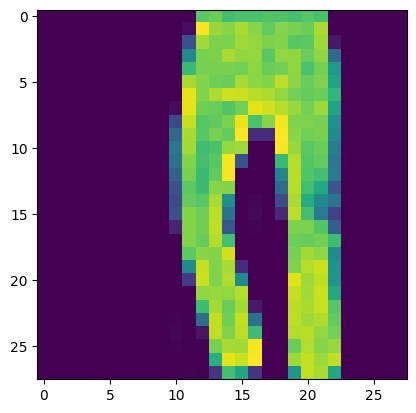

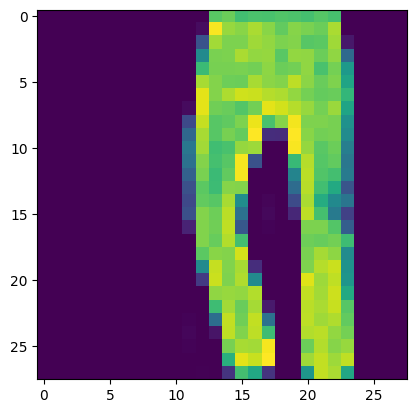

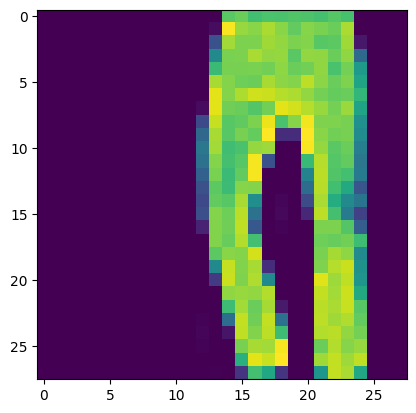

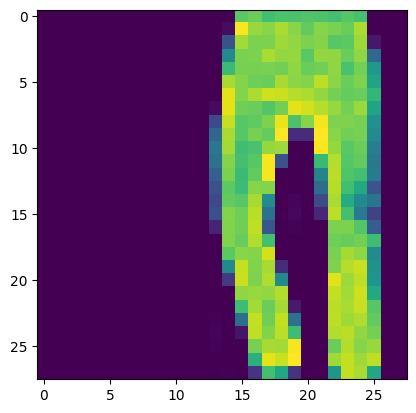

In [5]:
preds = []
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    plt.imshow(img2)
    plt.show()
    img3 = torch.Tensor(img2).view(28*28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

4. Visualize the predictions of the model for all the translations (-5 pixels to +5 pixels): 

In [6]:
preds

[array([2.9778915e-02, 3.9078651e-07, 1.1197253e-04, 1.8204909e-03,
        1.4211884e-04, 3.1509314e-13, 9.6812618e-01, 5.3556232e-13,
        1.9859079e-05, 1.1326248e-12], dtype=float32),
 array([2.0559901e-02, 3.7562288e-06, 1.8027780e-03, 1.3377212e-02,
        2.6926585e-02, 1.3599473e-10, 9.3732095e-01, 8.7918423e-11,
        8.8162569e-06, 1.1484768e-09], dtype=float32),
 array([5.73627502e-02, 2.37509049e-03, 3.10574640e-02, 5.85661456e-02,
        6.86270833e-01, 5.99343153e-09, 1.64232567e-01, 1.21269395e-08,
        1.35043403e-04, 1.69160714e-07], dtype=float32),
 array([1.0314665e-06, 9.9989921e-01, 1.6142453e-06, 9.7036582e-06,
        8.7333567e-05, 1.1446351e-14, 1.1729391e-06, 6.2798685e-17,
        6.8082073e-10, 3.1705338e-14], dtype=float32),
 array([9.8972623e-07, 9.9999857e-01, 3.3210055e-09, 2.3995705e-07,
        1.9379033e-07, 3.1577370e-16, 2.4760537e-08, 8.4711204e-23,
        9.6698023e-12, 2.0291970e-17], dtype=float32),
 array([5.0712597e-02, 9.4638169e-0

<Axes: title={'center': 'Probability of each class for various translations'}>

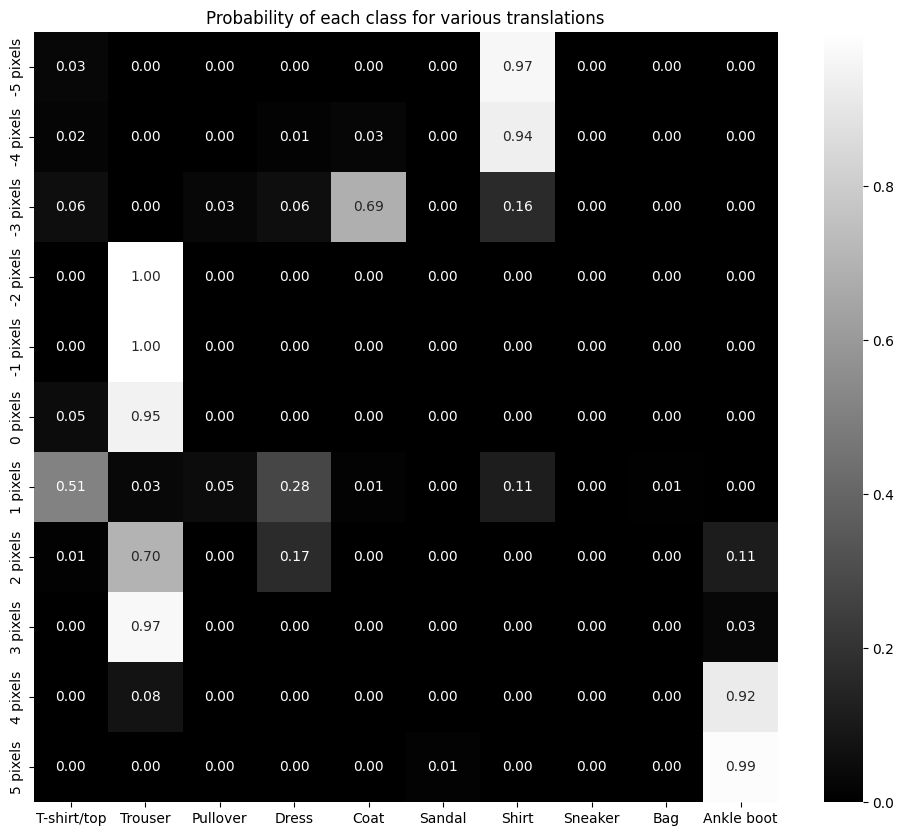

In [7]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes,yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')


There was no change in the image’s content since we only translated the images from 5 pixels to the left and 5 pixels to the right. However, the predicted class of the image changed when the translation was beyond 2 pixels. This is because, while the model was being trained, the content in all the training and testing images was at the center. This differs from the preceding scenario where we tested with translated images that are off-center (by a margin of 5 pixels), resulting in an incorrectly predicted class.

Now that we have learned about a scenario where a traditional neural network fails, we will learn how CNNs help address this problem. But before we do this, let’s first look at the building blocks of a CNN.

## Classifying images using deep CNNs

So far, we have seen that the traditional neural network predicts incorrectly for translated images. This needs to be addressed because, in real-world scenarios, various augmentations will need to be applied, such as translation and rotation, that were not seen during the training phase. In this section, we will understand how CNNs address the problem of incorrect predictions when image translation happens on images in the Fashion-MNIST dataset.

The preprocessing portion of the Fashion-MNIST dataset remains the same as in the previous chapter, except when we reshape (`.view`) the input data, where instead of flattening the input to 28 x 28 = 784 dimensions, we reshape the input to a shape of (1,28,28) for each image (remember, channels are to be specified first, followed by their height and width, in PyTorch):

1. Import the necessary packages: 

2. The Fashion-MNIST dataset class is defined as follows. Remember, the `Dataset` object will **always** need the `__init__`, `__getitem__`, and `__len__` methods we’ve defined: 

In [8]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

The `.view` is where we are reshaping each input image (differently from what we did in the previous chapter) since we are providing data to a CNN that expects each input to have a shape of batch size x channels x height x width.

3. The CNN model architecture is defined as follows: 

In [9]:
from torch.optim import Adam

def get_model():
    model = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3200, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

4. A summary of the model can be created using the following code: 

In [10]:
from torchsummary import summary

model, loss_fn, optimizer = get_model()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

Now, we train the model, just like we trained it in the previous chapter.

In [11]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [12]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

Epoch 0:	Train Loss: 0.4294	Train Accuracy: 0.8414	Val Loss: 0.3568	Val Accuracy: 0.8711
Epoch 1:	Train Loss: 0.2792	Train Accuracy: 0.8962	Val Loss: 0.2822	Val Accuracy: 0.8986
Epoch 2:	Train Loss: 0.2312	Train Accuracy: 0.9137	Val Loss: 0.2613	Val Accuracy: 0.9062
Epoch 3:	Train Loss: 0.1963	Train Accuracy: 0.9268	Val Loss: 0.2589	Val Accuracy: 0.9082
Epoch 4:	Train Loss: 0.1645	Train Accuracy: 0.9377	Val Loss: 0.2659	Val Accuracy: 0.9057


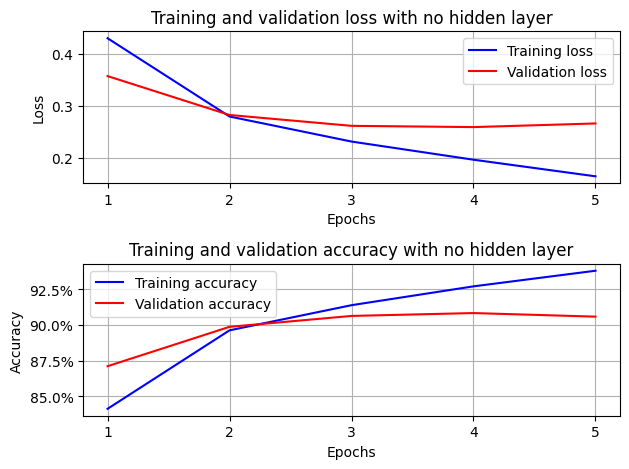

In [13]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, loss_fn, optimizer, trn_dl, val_dl)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Note that in the preceding scenario, the accuracy of the validation dataset is ~92% within the first five epochs, which is already better than the accuracy we saw across various techniques in the previous chapter, even without additional regularization.

Let’s translate the image and predict the class of translated images:

1. Translate the image between -5 pixels to +5 pixels and predict its class: 

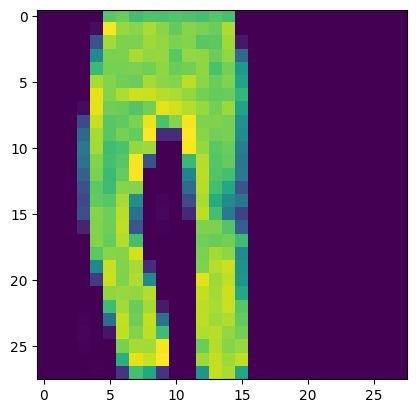

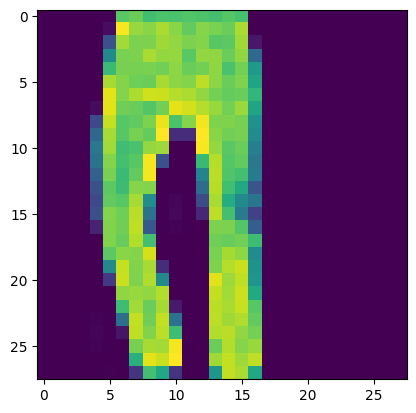

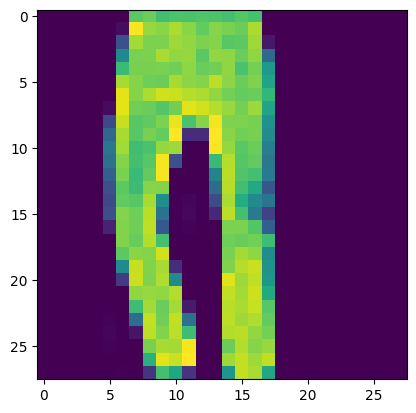

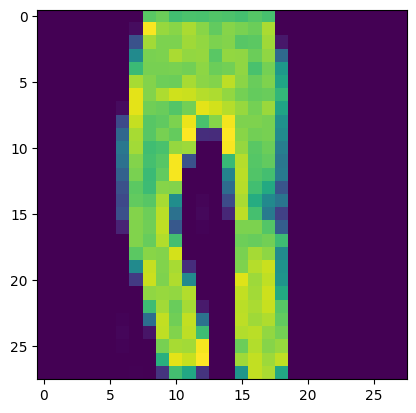

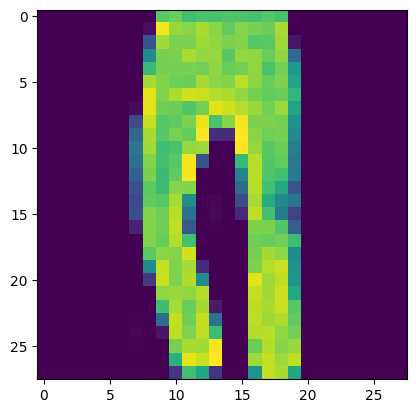

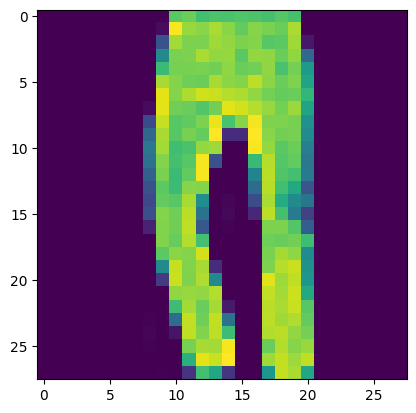

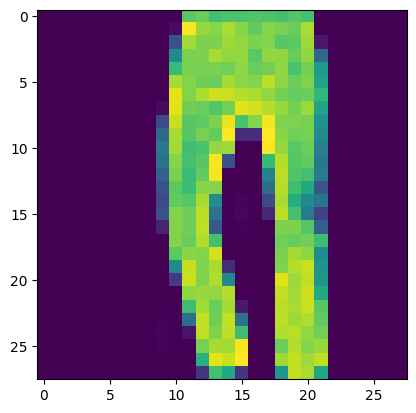

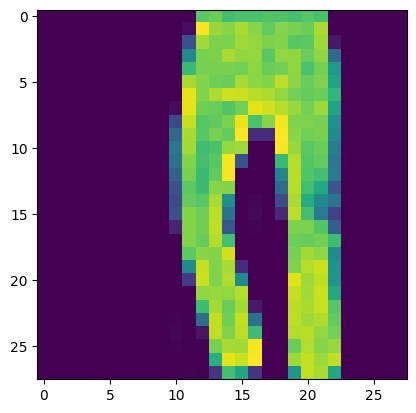

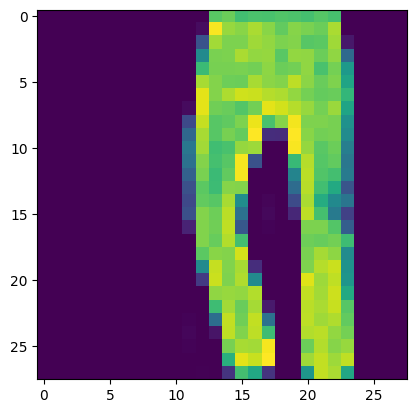

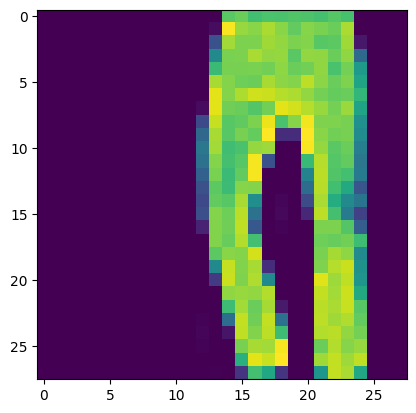

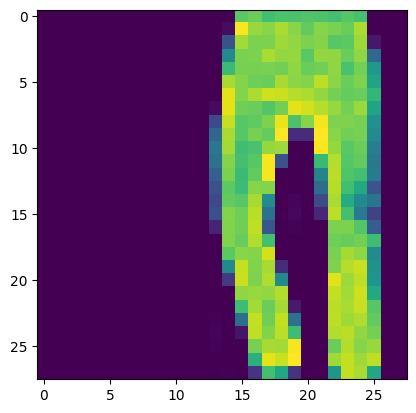

In [14]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    plt.imshow(img2)
    plt.show()
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

In the preceding code, we reshaped the image (`img3`) so it has a shape of `(-1,1,28,28)`, which will enable us to pass the image to a CNN model.

2. Plot the probability of the classes across various translations: 

<Axes: title={'center': 'Probability of each class for various translations'}>

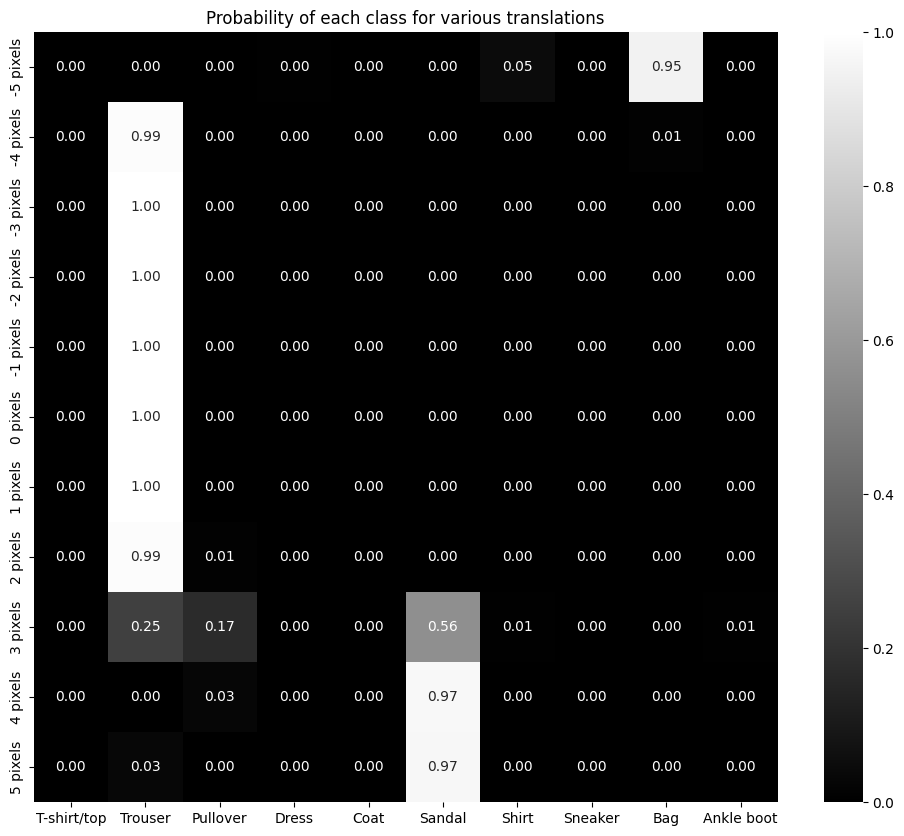

In [15]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax,fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')


Note that in this scenario, even when the image was translated by 4 pixels, the prediction was correct, while in the scenario where we did not use a CNN (earlier), the prediction was incorrect when the image was translated by 4 pixels. Furthermore, when the image was translated by 5 pixels, the probability of **Trouser** dropped considerably.

As we can see, while CNNs help in addressing the challenge of image translation, they don’t solve the problem at hand completely. We will learn how to address such a scenario by leveraging data augmentation alongside CNNs.

## Building a CNN for classifying real-world images

So far, we have learned how to perform image classification on the Fashion-MNIST dataset. In this section, we’ll do the same for a more real-world scenario, where the task is to classify images containing cats or dogs. We will also learn how the accuracy of the dataset varies when we change the number of images available for training.

1. Import the necessary packages: 

In [16]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2. Load the dataset, as follows:

In [17]:
train_data_dir = 'data/cat_and_dog/training_set/training_set'
test_data_dir = 'data/cat_and_dog/test_set/test_set'

3. Build a class that fetches data from the preceding folders. Then, based on the directory the image corresponds to, provide a label of 1 for dog images and a label of 0 for cat images. Furthermore, ensure that the fetched image has been normalized to a scale between 0 and 1 and permute it so that channels are provided first (as PyTorch models expect to have channels specified first, before the height and width of the image) – performed as follows:

    1. Define the `__init__` method, which takes a folder as input and stores the file paths (image paths) corresponding to the images in the `cats` and `dogs` folders in separate objects, post concatenating the file paths into a single list:
    2. Next, randomize the file paths and create target variables based on the folder corresponding to these file paths:
    3. Define the `__len__` method, which corresponds to the `self` class:
    4. Define the `__getitem__` method, which we use to specify a random file path from the list of file paths, read the image, and resize all the images so that they’re 224 x 224 in size. Given that our CNN expects the inputs from the channel to be specified first for each image, we will permute the resized image so that channels are provided first before we return the scaled image and the corresponding `target` value:

In [18]:
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs

        import random
        random.seed(10)
        random.shuffle(self.fpaths)

        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0

    def __len__(self): 
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

4. Inspect a random image:

In [19]:
data = cats_dogs(train_data_dir)
im, label = data[200]

Visualize the image: We need to permute the image we’ve obtained to our channels last. This is because matplotlib expects an image to have the channels specified after the height and width of the image have been provided:

tensor([1.], device='cuda:0')


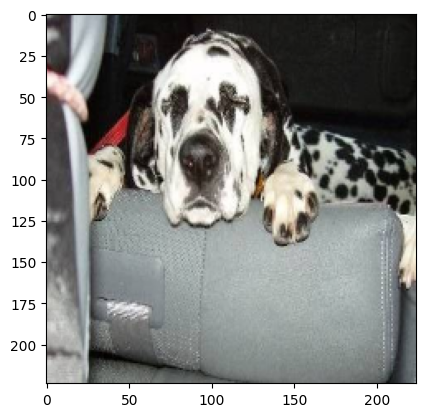

In [20]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

5. Define a model, loss function, and optimizer, as follows:
    1. First, we must define the `conv_layer` function, where we perform convolution, ReLU activation, batch normalization, and max pooling in that order. This method will be reused in the final model, which we will define in the next step:

In [21]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

In the preceding code, we are taking the number of input channels (`ni`), number of output channels (`no`), `kernel_size`, and the `stride` of filters as input for the `conv_layer` function.

5. 
    2. Define the `get_model` function, which performs multiple convolutions and pooling operations (by calling the `conv_layer` method), flattens the output, and connects a hidden layer to it prior to connecting to the output layer:

In [22]:
def get_model():
    model = nn.Sequential(
              conv_layer(3, 64, 3),
              conv_layer(64, 512, 3),
              conv_layer(512, 512, 3),
              conv_layer(512, 512, 3),
              conv_layer(512, 512, 3),
              conv_layer(512, 512, 3),
              nn.Flatten(),
              nn.Linear(512, 1),
              nn.Sigmoid(),
            ).to(device)

    loss_fn = nn.BCELoss()
    optimizer=torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

5. 
    3. Now, we must call the `get_model` function to fetch the model, loss function (`loss_fn`), and `optimizer` and then summarize the model using the `summary` method that we imported from the `torchsummary` package:

In [23]:
from torchsummary import summary

model, loss_fn, optimizer = get_model()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

6. Create the `get_data` function, which creates an object of the `cats_dogs` class and creates a `DataLoader` with a `batch_size` of 32 for both the training and validation folders: 

In [24]:
def get_data():
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val,batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In the preceding code, we are ignoring the last batch of data by specifying that `drop_last = True`. We’re doing this because the last batch might not be the same size as the other batches.

7. Define the functions for calculating accuracy:

In [25]:
@torch.no_grad()
def accuracy(prediction, y):
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

8. Train the model for `5` epochs and check the accuracy of the test data at the end of each epoch, as we’ve done in previous sections:

    1. Define the model and fetch the required DataLoaders:

In [26]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

8. 
    2. Train the model over increasing epochs:


In [27]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, loss_fn, optimizer, trn_dl, val_dl)

Epoch 0:	Train Loss: 0.6701	Train Accuracy: 0.6364	Val Loss: 0.6461	Val Accuracy: 0.6538
Epoch 1:	Train Loss: 0.5281	Train Accuracy: 0.7399	Val Loss: 0.5072	Val Accuracy: 0.7470
Epoch 2:	Train Loss: 0.4084	Train Accuracy: 0.8196	Val Loss: 0.5244	Val Accuracy: 0.7500
Epoch 3:	Train Loss: 0.3160	Train Accuracy: 0.8600	Val Loss: 0.3088	Val Accuracy: 0.8686
Epoch 4:	Train Loss: 0.2515	Train Accuracy: 0.8936	Val Loss: 0.2867	Val Accuracy: 0.8755


9. Plot the variation of the training and validation accuracies over increasing epochs: 

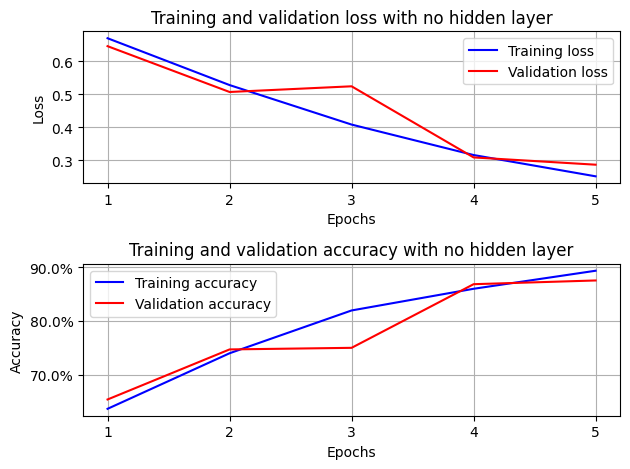

In [28]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Summary

Traditional neural networks fail when new images that are very similar to previously seen images that have been translated are fed as input to the model. CNNs play a key role in addressing this shortcoming. This is enabled through the various mechanisms that are present in CNNs, including filters, strides, and pooling.

In the next chapter, we will learn how to leverage various transfer learning techniques to increase the accuracy of the test dataset, even when we have just a small amount of training data.